In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt


sys.path.append('../')

from BGS import BGS
from HST import HST

from FileEmcee import FileEmcee
from EmceeRun import EmceeRun

from Plotter import Plotter
from PlotterHst import PlotterHst

from VMaxDensity import VmaxDensity
from VMaxDensityHst import VmaxDensityHst

from ZSchechterModel import ZSchechterModel
from NoZSchechterModel import NoZSchechterModel

from Fileh5 import Fileh5

# 3D-HST Leja et al.

In [2]:
hst = HST('3dhst_master.phot.v4.1.cat.lite.hdf5')

In [3]:
emcee_file = Fileh5(folder='emcee_runs/bin_tests_runs/HST', info_file='0.65_0.69')

In [4]:
emcee_run = EmceeRun(emcee_file)

In [5]:
plotter_hst = PlotterHst(hst, emcee_run)

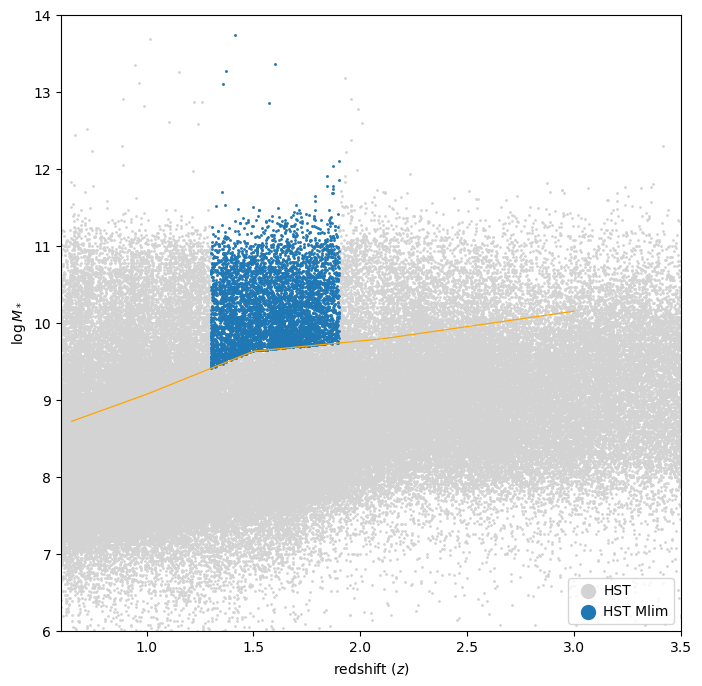

In [6]:
plt.figure(figsize=(8,8))
plotter_hst.plot_selected_data(1.30, 1.90)

In [7]:
vmax_hst = VmaxDensityHst(hst.file)
h, b = vmax_hst.histogram_norm(1.30, 1.90)

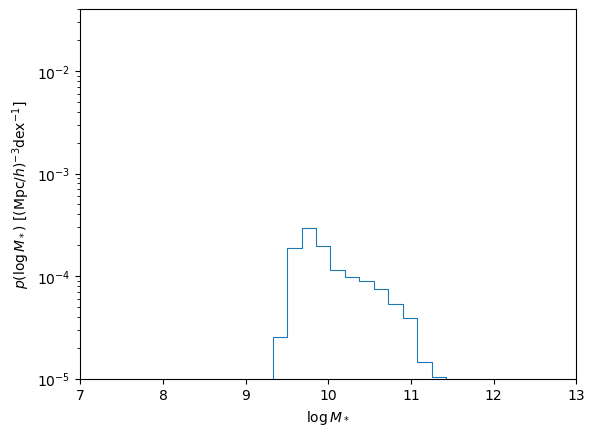

In [8]:
PlotterHst.plot_vmax_hist(h, b, h, b)

In [ ]:
hst.get_number_galaxies(bin=True, zmin=0.65, zmax=0.69)

In [ ]:
z, x = hst.select_galaxies(0.65, 0.69)

In [ ]:
NoZSchechterModel.phi(x, 10., -0.2)

In [ ]:
z, x = hst.select_galaxies(0.65, 0.69)

In [ ]:
# plotter_hst.plot_emcee_samples()

In [ ]:
z, x = gathering_data(hst, 0.65, 3.0)

In [ ]:
z_lin = np.linspace(0.65, 3.0, 100)
plt.figure(figsize=(8,8))
plt.plot(z, x, 'o', markersize=1)
plt.plot(z_lin, mass_completeness_limit(z_lin))
plt.xlabel(r"redshift ($z$)")
plt.ylabel(r"$\log M_*$")
# plt.xlim(0.5, 3.5)
plt.ylim(8., 15)


In [ ]:
footprint = 0.25 #deg^2

cosmo = FlatLambdaCDM(H0=67.8, Om0=0.307)

dmin3 = cosmo.comoving_distance(0.65).value ** 3
vmax = np.array([4*np.pi/3 * 0.25/41253 * (cosmo.comoving_distance(zmax(m_i)).value ** 3 - dmin3) for m_i in x])

In [ ]:
x_lin = np.linspace(x.min(), x.max(), 100)
for i in range(x_lin.shape[0]):
    plt.scatter(x_lin[i], zmax(x_lin[i]))

In [ ]:
vmax

In [ ]:
x_lin[10], zmax(x_lin[10])

In [ ]:
x_test = x[x<9.]
z_test = z[x<9]

In [ ]:
mass_completeness_limit(z_test[0])

In [ ]:
zmax(x_test[0])

In [ ]:
mass_completeness_limit(3.0)

In [ ]:
z_lin = np.linspace(0.65, 3.0, 100)
plt.figure(figsize=(8,8))
plt.plot(z_test, x_test, 'o', markersize=1)
plt.plot(z_lin, mass_completeness_limit(z_lin))
plt.xlabel(r"redshift ($z$)")
plt.ylabel(r"$\log M_*$")
# plt.xlim(0.5, 3.5)
plt.ylim(8., 15)


In [ ]:
cosmo.comoving_distance()

In [ ]:
write_table_hdf5(hst['lmass', 'z_peak'], '3dhst_master.phot.v4.1.cat.lite.hdf5', overwrite=True)

In [ ]:
x.shape

In [ ]:
lmass = hst['lmass']
# z_spec = hst['z_spec']
z_peak = hst['z_peak']

# mask_spec = (z_spec >= 0.)
mask_peak = (z_peak >= 0.) & (lmass > 0.)

In [ ]:
mass_complete = np.array(list(zip([0.65, 1.0, 1.5, 2.1, 3.0], [8.72, 9.07, 9.63, 9.79, 10.15])))

In [ ]:
mass_complete[:,0]


In [ ]:
hst['lmass','z_peak'].to_pandas().to_hdf('3dhst_master.phot.v4.1.cat.lite.hdf5', key='hst_lite', mode='w')

In [ ]:
# cosmos = h5py.File('../data/COSMOS2015_Laigle+_v1.1.lite.hdf5')

In [ ]:
cosmos = aTable.Table.read('../data/COSMOS2015_Laigle+_v1.1.lite.hdf5')

In [ ]:
# z, x = gathering_data(cosmos, 0.175, 4.4)

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(z, x, 'o', markersize=0.3)
plt.plot(np.linspace(0.175, 4.4, 100), mass_completeness_limit(np.linspace(0.175, 4.4, 100)))
# plt.plot(mass_complete_cosmos[:,0], mass_complete_cosmos[:,1])
# plt.plot(np.linspace(x_values[0],x_values[-1],100), mass_completeness_cosmos(np.linspace(x_values[0],x_values[-1],100)))

In [ ]:
z.shape

In [ ]:
z_cosmos = cosmos['ZPDF']
m_cosmos = cosmos['MASS_MED']
mask = (z_cosmos >= .175) & (z_cosmos <= 4.4) & (m_cosmos > 8.1)
z = z_cosmos[mask]
mask_lim = m_cosmos > mass_completeness_cosmos(z)
mstar = m_cosmos[mask_lim]
z = z_cosmos[mask_lim]

In [ ]:
mass_complete_cosmos = np.array(list(zip([0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4], 
                                         [8.1, 8.7, 9.1, 9.3, 9.7, 9.9, 10.0, 10.1, 10.1, 10.1])))

In [ ]:
x_values = [0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4]

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(z, x, 'o', markersize=1)
plt.plot(mass_complete_cosmos[:,0], mass_complete_cosmos[:,1])
plt.plot(np.linspace(x_values[0],x_values[-1],100), mass_completeness_cosmos(np.linspace(x_values[0],x_values[-1],100)))

plt.xlabel(r"redshift ($z$)")
plt.ylabel(r"$\log M_*$")
# plt.xlim(0.5, 3.5)
# plt.ylim(8., 15)

In [ ]:

x_values = [0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4]
y_values = [8.1, 8.7, 9.1, 9.3, 9.7, 9.9, 10.0, 10.1, 10.1, 10.1]

f = interp1d(x_values, y_values)

In [ ]:
f(1.3)

In [ ]:
def mass_completeness_cosmos(x):
    
    x_values = [0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4]
    y_values = [8.1, 8.7, 9.1, 9.3, 9.7, 9.9, 10.0, 10.1, 10.1,10.1]

    f = interp1d(x_values, y_values)
    return f(x)

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(z_cosmos[mask], m_cosmos[mask], 'o', markersize=1)
plt.plot(mass_complete_cosmos[:,0], mass_complete_cosmos[:,1])
plt.plot(np.linspace(x_values[0], x_values[-1], 100), mass_completeness_cosmos(np.linspace(x_values[0], x_values[-1], 100)))
plt.xlabel(r"redshift ($z$)")
plt.ylabel(r"$\log M_*$")
# plt.xlim(0.5, 3.5)
# plt.ylim(8., 15)
# plt.plot(np.linspace(1, 10, 100), mass_completeness_cosmos(np.linspace(1, 10, 100)))

# COSMOS2015 Laigle et al. 2016

In [ ]:
cosmos2015 = Table.read('../data/COSMOS2015_Laigle+_v1.1.fits')

In [ ]:
write_table_hdf5(cosmos2015['ZPDF', 'MASS_MED'], 'COSMOS2015_Laigle+_v1.1.lite.hdf5')

In [ ]:
cosmos2015[:5]

In [ ]:
mask_flag = (cosmos2015['FLAG_DEEP'] == 1)

In [ ]:
c = cosmos2015['ZPDF'][mask_flag]

In [ ]:
c[:5]

In [ ]:
z_cosmos = cosmos2015['ZPDF']
m_cosmos = cosmos2015['MASS_MED']
mask = (z_cosmos >= 0.) & (m_cosmos > 0.)

In [ ]:
mass_complete_cosmos = np.array(list(zip([0.175, 0.5, 0.8, 1.125, 1.525, 2.0, 2.5, 3.125, 3.75, 4.4], 
                                         [8.1, 8.7, 9.1, 9.3, 9.7, 9.9, 10.0, 10.1, 10.1])))

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(z_cosmos[mask], m_cosmos[mask], 'o', markersize=1)
plt.plot(mass_complete_cosmos[:,0], mass_complete_cosmos[:,1])
plt.xlabel(r"redshift ($z$)")
plt.ylabel(r"$\log M_*$")
# plt.xlim(0.5, 3.5)
# plt.ylim(8., 15)


In [ ]:
cosmos2015['ZPDF', 'MASS_MED'].to_pandas().to_hdf('../data/COSMOS2015_Laigle+_v1.1.lite.hdf5', key='cosmos_lite', mode='w')